<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/AMLProject.wil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet101

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

C:\Users\typin\AppData\Local\R-MINI~1\envs\aml-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    ! pip install torchvision
    ! pip install torchinfo

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

## Show device available

In [5]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Show model arquitecture

In [6]:
from torchinfo import summary
import modular.models as models
from prettytable import PrettyTable

In [7]:
amlresnet101 = models.AMLResnet101(out_dim=10)

In [8]:
batch_size = 16
img_size = 232
summary(model=amlresnet101, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet101 (AMLResnet101)                   [32, 3, 232, 232]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 232, 232]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   (128)                False
│    └─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
│    └─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58,

In [9]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
_ = count_parameters(amlresnet101)

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.1.weight |    2048    |
|  fc.1.bias  |    2048    |
| fc.3.weight |  1048576   |
|  fc.3.bias  |    512     |
| fc.5.weight |    512     |
|  fc.5.bias  |    512     |
| fc.7.weight |    5120    |
|  fc.7.bias  |     10     |
+-------------+------------+
Total Trainable Params: 1059338


## Fine tunning

In [10]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet101 = models.AMLResnet101(out_dim=10)
# Let base train
amlresnet101.unfreeze_base()

train_transforms, validate_transforms = amlresnet101.transforms, amlresnet101.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=amlresnet101.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 2

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('trained/finetune.amlresnet101.pth')

# Mini batch
batch_size=16

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [11]:
results = train(model=amlresnet101,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.03it/s]
2it [00:01,  1.31it/s]
3it [00:02,  1.56it/s]
4it [00:02,  1.73it/s]
5it [00:03,  1.79it/s]
6it [00:03,  1.86it/s]
7it [00:04,  1.90it/s]
8it [00:04,  1.92it/s]
9it [00:05,  1.96it/s]
10it [00:05,  1.99it/s]
11it [00:06,  2.00it/s]
12it [00:06,  2.02it/s]
13it [00:07,  2.03it/s]
14it [00:07,  2.04it/s]
15it [00:08,  2.05it/s]
16it [00:08,  2.05it/s]
17it [00:08,  2.05it/s]
18it [00:09,  2.06it/s]
19it [00:09,  2.07it/s]
20it [00:10,  2.07it/s]
21it [00:10,  2.04it/s]
22it [00:11,  2.03it/s]
23it [00:11,  2.04it/s]
24it [00:12,  2.06it/s]
25it [00:12,  2.06it/s]
26it [00:13,  2.08it/s]
27it [00:13,  2.08it/s]
28it [00:14,  2.09it/s]
29it [00:14,  2.09it/s]
30it [00:15,  2.09it/s]
31it [00:15,  2.09it/s]
32it [00:16,  2.09it/s]
33it [00:16,  2.09it/s]
34it [00:17,  2.09it/s]
35it [00:17,  2.09it/s]
36it [00:18,  2.09it/s]
37it [

Epoch: 1 | train_loss: 1.7132 | train_acc: 0.3843 | test_loss: 1.1572 | test_acc: 0.5865


 50%|█████████████████████████████████████████                                         | 1/2 [21:36<21:36, 1296.17s/it]
0it [00:00, ?it/s]
1it [00:00,  2.12it/s]
2it [00:00,  2.11it/s]
3it [00:01,  2.11it/s]
4it [00:01,  2.11it/s]
5it [00:02,  2.09it/s]
6it [00:02,  2.10it/s]
7it [00:03,  2.11it/s]
8it [00:03,  2.11it/s]
9it [00:04,  2.11it/s]
10it [00:04,  2.12it/s]
11it [00:05,  2.11it/s]
12it [00:05,  2.12it/s]
13it [00:06,  2.11it/s]
14it [00:06,  2.12it/s]
15it [00:07,  2.12it/s]
16it [00:07,  2.12it/s]
17it [00:08,  2.11it/s]
18it [00:08,  2.12it/s]
19it [00:08,  2.11it/s]
20it [00:09,  2.11it/s]
21it [00:09,  2.11it/s]
22it [00:10,  2.11it/s]
23it [00:10,  2.10it/s]
24it [00:11,  2.10it/s]
25it [00:11,  2.10it/s]
26it [00:12,  2.10it/s]
27it [00:12,  2.11it/s]
28it [00:13,  2.10it/s]
29it [00:13,  2.10it/s]
30it [00:14,  2.10it/s]
31it [00:14,  2.11it/s]
32it [00:15,  2.11it/s]
33it [00:15,  2.10it/s]
34it [00:16,  2.11it/s]
35it [00:16,  2.11it/s]
36it [00:17,  2.11it/s]
37it [

Epoch: 2 | train_loss: 1.3122 | train_acc: 0.5361 | test_loss: 0.9139 | test_acc: 0.6773


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [42:57<00:00, 1288.63s/it]


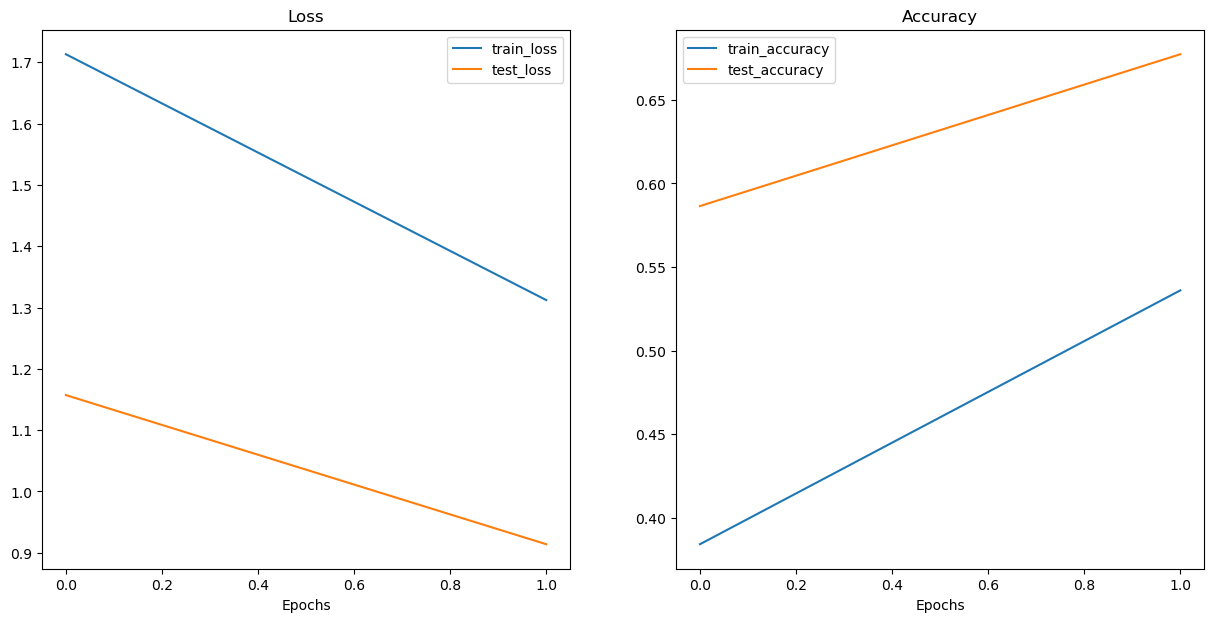

In [12]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

## Training find tunning AMLResnet101

In [13]:
import torch
from pathlib import Path

saved_data = torch.load(Path('trained/finetune.amlresnet101.pth'))
saved_data.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch', 'optimizer', 'model'])

In [14]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet101 = models.AMLResnet101(out_dim=10)
# Recover state dict
state_dict = saved_data['model']
# Load saved state dict into the model
amlresnet101.load_state_dict(state_dict)
# Freeze base
amlresnet101.freeze_base()

train_transforms, validate_transforms = amlresnet101.transforms, amlresnet101.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=amlresnet101.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('trained/amlresnet101.pth')

# Mini batch
batch_size=125

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [15]:
results = train(model=amlresnet101,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:03,  3.91s/it]
2it [00:05,  2.33s/it]
3it [00:06,  1.82s/it]
4it [00:07,  1.58s/it]
5it [00:08,  1.45s/it]
6it [00:09,  1.36s/it]
7it [00:11,  1.34s/it]
8it [00:12,  1.30s/it]
9it [00:13,  1.27s/it]
10it [00:14,  1.25s/it]
11it [00:16,  1.24s/it]
12it [00:17,  1.23s/it]
13it [00:18,  1.22s/it]
14it [00:19,  1.22s/it]
15it [00:20,  1.22s/it]
16it [00:22,  1.22s/it]
17it [00:23,  1.22s/it]
18it [00:24,  1.22s/it]
19it [00:25,  1.22s/it]
20it [00:27,  1.22s/it]
21it [00:28,  1.22s/it]
22it [00:29,  1.21s/it]
23it [00:30,  1.22s/it]
24it [00:31,  1.22s/it]
25it [00:33,  1.22s/it]
26it [00:34,  1.21s/it]
27it [00:35,  1.22s/it]
28it [00:36,  1.22s/it]
29it [00:37,  1.22s/it]
30it [00:39,  1.22s/it]
31it [00:40,  1.22s/it]
32it [00:41,  1.21s/it]
33it [00:42,  1.22s/it]
34it [00:44,  1.21s/it]
35it [00:45,  1.22s/it]
36it [00:46,  1.22s/it]
37it [

Epoch: 1 | train_loss: 0.9898 | train_acc: 0.6518 | test_loss: 0.7607 | test_acc: 0.7320


 10%|████████                                                                        | 1/10 [07:57<1:11:37, 477.54s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.22s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.21s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.22s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.22s/it]
18it [00:21,  1.21s/it]
19it [00:23,  1.21s/it]
20it [00:24,  1.21s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.21s/it]
23it [00:27,  1.21s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.21s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.21s/it]
33it [00:40,  1.22s/it]
34it [00:41,  1.21s/it]
35it [00:42,  1.22s/it]
36it [00:43,  1.22s/it]
37it [

Epoch: 2 | train_loss: 0.9112 | train_acc: 0.6771 | test_loss: 0.7513 | test_acc: 0.7372


 20%|████████████████                                                                | 2/10 [15:51<1:03:25, 475.67s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.21s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.21s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.21s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.22s/it]
18it [00:21,  1.21s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.21s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.22s/it]
23it [00:27,  1.22s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.22s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.21s/it]
33it [00:40,  1.21s/it]
34it [00:41,  1.21s/it]
35it [00:42,  1.21s/it]
36it [00:43,  1.21s/it]
37it [

Epoch: 3 | train_loss: 0.9449 | train_acc: 0.6660 | test_loss: 0.7389 | test_acc: 0.7398


 30%|████████████████████████▌                                                         | 3/10 [23:46<55:25, 475.00s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.22s/it]
4it [00:04,  1.22s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.22s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.21s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.21s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.22s/it]
18it [00:21,  1.22s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.22s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.21s/it]
23it [00:27,  1.22s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.22s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.22s/it]
33it [00:40,  1.22s/it]
34it [00:41,  1.22s/it]
35it [00:42,  1.22s/it]
36it [00:43,  1.22s/it]
37it [

Epoch: 4 | train_loss: 0.9346 | train_acc: 0.6701 | test_loss: 0.7254 | test_acc: 0.7476


 40%|████████████████████████████████▊                                                 | 4/10 [31:40<47:29, 474.93s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.21s/it]
4it [00:04,  1.22s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.22s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.22s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.21s/it]
16it [00:19,  1.21s/it]
17it [00:20,  1.23s/it]
18it [00:21,  1.22s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.22s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.22s/it]
23it [00:28,  1.22s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.21s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.22s/it]
33it [00:40,  1.22s/it]
34it [00:41,  1.22s/it]
35it [00:42,  1.22s/it]
36it [00:43,  1.22s/it]
37it [

KeyboardInterrupt: 

In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)